# Transfer Learning with Dataset: EMNIST

Imports

In [80]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from extra_keras_datasets import emnist
import matplotlib.pyplot as plt

Load Dataset

In [81]:
print("Loading EMNIST dataset...")
(x_train, y_train), (x_test, y_test) = emnist.load_data(type='balanced')

# separate x_train and y_train into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

# sort out everything except hex digits (A-F, 0-9)
hex_labels = list(range(0, 10)) + list(range(10, 16))

# Filter the training set
bool_train_idxs = np.isin(y_train, hex_labels)
x_train_hex = x_train[bool_train_idxs]
y_train_hex = y_train[bool_train_idxs]

# Filter the validation set
bool_val_idxs = np.isin(y_val, hex_labels)
x_val_hex = x_val[bool_val_idxs]
y_val_hex = y_val[bool_val_idxs]

# Filter the test set
bool_test_idxs = np.isin(y_test, hex_labels)
x_test_hex = x_test[bool_test_idxs]
y_test_hex = y_test[bool_test_idxs]

INFO:root:Loading dataset = emnist


Loading EMNIST dataset...


Plot some digits:

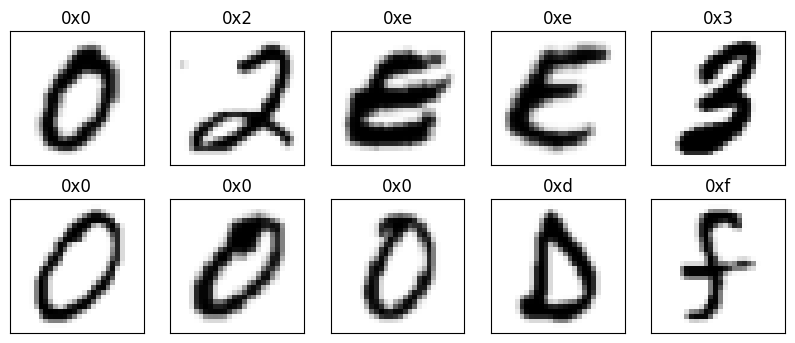

In [84]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train_hex[i], cmap='binary')
    ax.set_title(hex(y_train_hex[i]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


Normalize the set:

In [85]:
# Convert and preprocess the training data
x_train_hex = x_train_hex.reshape(-1, 28, 28, 1)
x_train_hex = x_train_hex.astype('float32')
x_train_hex /= 255
y_train_hex = keras.utils.to_categorical(y_train_hex, 16)

# Convert and preprocess the validation data
x_val_hex = x_val_hex.reshape(-1, 28, 28, 1)
x_val_hex = x_val_hex.astype('float32')
x_val_hex /= 255
y_val_hex = keras.utils.to_categorical(y_val_hex, 16)

# Convert and preprocess the testing data
x_test_hex = x_test_hex.reshape(-1, 28, 28, 1)
x_test_hex = x_test_hex.astype('float32')
x_test_hex /= 255
y_test_hex = keras.utils.to_categorical(y_test_hex, 16)

print("Training set shape:", x_train_hex.shape)
print("Training labels shape:", y_train_hex.shape)
print("Validation set shape:", x_val_hex.shape)
print("Validation labels shape:", y_val_hex.shape)
print("Testing set shape:", x_test_hex.shape)
print("Testing labels shape:", y_test_hex.shape)

Training set shape: (30796, 28, 28, 1)
Training labels shape: (30796, 16)
Validation set shape: (7604, 28, 28, 1)
Validation labels shape: (7604, 16)
Testing set shape: (6400, 28, 28, 1)
Testing labels shape: (6400, 16)


Load the previous cnn model:

In [86]:
current_path = os.path.abspath("")
base_model = tf.keras.models.load_model(os.path.join(current_path, 'models', 'cnn_mnist.h5'))

# remove the last layer
base_model.pop()

base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
Total params: 19,328
Trainable params: 19,328
Non-trai

Freeze the model and add layers:

In [87]:
inputs = tf.keras.Input(shape=(28, 28, 1))
x = base_model(inputs, training=False)

# Add a new dense layer for classification
last_layer = tf.keras.layers.Dense(16)(x)
output = tf.keras.layers.Activation('softmax')(last_layer)

model = tf.keras.Model(inputs, output)

Compile the model:

In [88]:
model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              metrics=['accuracy'])

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 1600)              19328     
                                                                 
 dense_9 (Dense)             (None, 16)                25616     
                                                                 
 activation_5 (Activation)   (None, 16)                0         
                                                                 
Total params: 44,944
Trainable params: 44,944
Non-trainable params: 0
_________________________________________________________________


Determine accuracy:

In [90]:
# determine accuaracy before training
loss0, acc0 = model.evaluate(x = x_test_hex, y = y_test_hex)

200/200 [==============================] - 1s 3ms/step - loss: 3.9841 - accuracy: 0.0527


Train the model for 10 epochs:

In [93]:
# train model for 10 epochs
history = model.fit(x_train_hex, y_train_hex, batch_size=128, epochs=10, verbose=2, validation_data= (x_val_hex, y_val_hex))

Epoch 1/10
241/241 - 6s - loss: 1.2239 - accuracy: 0.6515 - val_loss: 0.4124 - val_accuracy: 0.8891 - 6s/epoch - 26ms/step
Epoch 2/10
241/241 - 6s - loss: 0.3035 - accuracy: 0.9157 - val_loss: 0.2500 - val_accuracy: 0.9317 - 6s/epoch - 26ms/step
Epoch 3/10
241/241 - 6s - loss: 0.2067 - accuracy: 0.9402 - val_loss: 0.1967 - val_accuracy: 0.9429 - 6s/epoch - 24ms/step
Epoch 4/10
241/241 - 6s - loss: 0.1653 - accuracy: 0.9530 - val_loss: 0.1676 - val_accuracy: 0.9513 - 6s/epoch - 24ms/step
Epoch 5/10
241/241 - 6s - loss: 0.1413 - accuracy: 0.9586 - val_loss: 0.1508 - val_accuracy: 0.9577 - 6s/epoch - 24ms/step
Epoch 6/10
241/241 - 6s - loss: 0.1243 - accuracy: 0.9638 - val_loss: 0.1411 - val_accuracy: 0.9587 - 6s/epoch - 24ms/step
Epoch 7/10
241/241 - 6s - loss: 0.1115 - accuracy: 0.9674 - val_loss: 0.1296 - val_accuracy: 0.9605 - 6s/epoch - 24ms/step
Epoch 8/10
241/241 - 6s - loss: 0.1028 - accuracy: 0.9698 - val_loss: 0.1217 - val_accuracy: 0.9633 - 6s/epoch - 24ms/step
Epoch 9/10
241/2

Plot accuracy / loss curves:

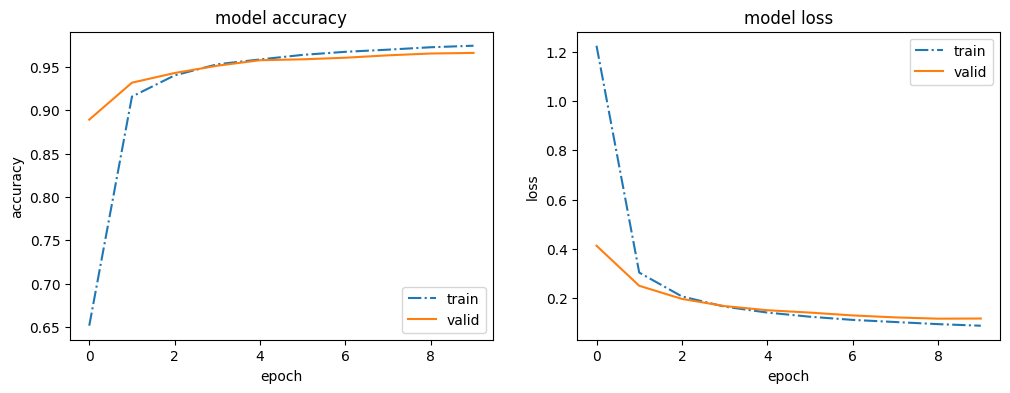

In [94]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

Create confusion matrix:

In [95]:
pred = model.predict(x_test_hex)
print(confusion_matrix(np.argmax(y_test_hex,axis=1),np.argmax(pred,axis=1)))
acc_fc_orig = np.sum(np.argmax(y_test_hex,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_orig_flat = " , acc_fc_orig)

200/200 [==============================] - 1s 3ms/step
[[386   0   1   0   0   0   2   0   0   0   2   0   0   9   0   0]
 [  0 395   2   0   1   0   0   0   0   0   0   0   0   1   0   1]
 [  0   0 390   2   1   0   0   0   3   0   0   1   0   3   0   0]
 [  1   0   0 393   0   3   0   0   1   1   0   1   0   0   0   0]
 [  1   0   0   0 383   0   0   0   1   4   5   1   1   1   0   3]
 [  1   0   1   2   1 386   1   0   1   3   0   0   2   0   0   2]
 [  0   1   0   0   0   1 396   0   0   0   0   0   1   0   0   1]
 [  1   1   1   1   2   0   0 389   0   3   0   0   0   1   0   1]
 [  0   1   0   0   0   3   0   0 378   5   1   9   0   1   1   1]
 [  0   0   0   0   1   0   0   4   2 392   0   0   1   0   0   0]
 [  1   0   4   0   2   0   0   0   1   1 388   2   0   1   0   0]
 [  2   0   2   0   0   1   1   0   6   0   4 380   1   0   3   0]
 [  5   0   1   0   0   0   4   0   0   0   0   0 387   0   2   1]
 [ 25   0   1   1   1   1   0   0   0   0   0   4   1 366   0   0]
 [  0  